In [2]:

!pip install xgboost


In [3]:
# 데이터 조작을 위한 프레임워크 numpy, pandas.
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# 특별한 데이터 조작을 위한 라이브러리 add on.
from itertools import product
from sklearn.preprocessing import LabelEncoder

# 사용할 시각화 툴 seaborn, pyplot.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# model은 xgboost을 사용합니다.
from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

# 메모리, 실행시간, 데이터 저장 등, 기타 목적을 위한 라이브러리들.
import time
import sys
import gc
import pickle
sys.version_info
#sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [5]:
#데이터를 읽어옵니다.

items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')


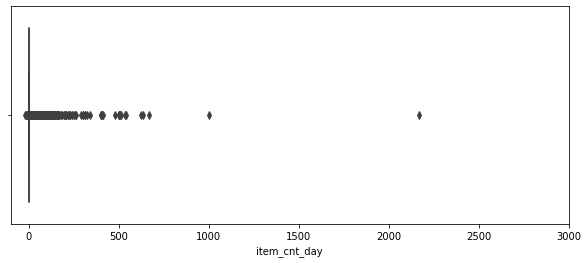

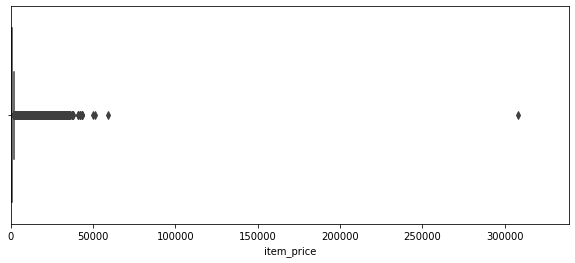

In [6]:
#가장 먼저, 이상값, 극단값이 있는지 먼저 살펴보겠습니다.

#데이터 features 중, item_price 와 item_cnt_day 를 살펴보면 다음과 같습니다.

plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)



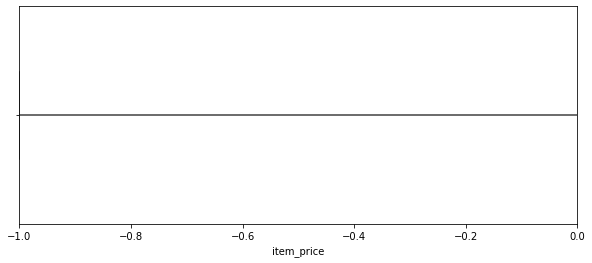

In [7]:
#각 플롯에 보이는 매우 극단적인 값들이 보입니다.
#이 데이터들은 일단 데이터셋에서 제외시키도록 하겠습니다.

train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]
#한편, price 도 살펴보겠습니다.

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), 0)
sns.boxplot(x=train.item_price)

In [9]:
#price가 0 미만인 '이상 값' 이 존재합니다.
#이 값을 해당 상품의 전 기간의 가격들 중, 중간값으로 바꿔주겠습니다.

median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median
#또 살펴본 결과, 일부 shop_id 가 shop_name 하고 맞지않는 데이터가 있었습니다.
#이 값들도 고쳐주겠습니다.

# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [10]:
#Shops/Cats/Items preprocessing
#shops, cats, items 에 있는 데이터로, 일부 새로운 Feature 를 만들어볼까 합니다.
#먼저, shops 부터 보겠습니다.
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
#Shops를 보면, shop_name의 첫 번째 단어가, 해당 상점이 해당하는 도시 이름입니다.
#예를 들어, 상점 이름이 "마포구 스타벅스" 식으로 되어있는 것이죠.
#따라서, shop_name 으로 부터, 도시 이름을 뽑아내고, 이를 새로운 Feature 로 둘 수 있습니다.
#이를 city 라고 하고, 이를 Label encoding 한 것을 city_code 라고 하겠습니다.

# 일부 데이터의 shop_name 이 통일되지 않는 게 있습니다. 이를 보정해줍니다.
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

# shop_name 으로부터 city 를 추출하여 새로운 Feature를 만듭니다.
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск' # Якутск 역시, 통일되지 않은 도시라 보정해줍니다.

# city 를 LabelEncoder 로 encoding 하여 새로운 Feature를 만듭니다.
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]


In [12]:
#이번엔 Cats를 보겠습니다.
cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [13]:
#item_category_name 를 보면, 첫 번째 단어와 두 번째 단어가 모두 서브 카테고리 이름임을 알 수 있습니다.
#예를 들어, 카테고리 이름이 "전자기기-노트북" 식으로 되어있는거죠.
#마찬가지로, 여기서 두 개의 카테고리를 뽑아내어 새로운 Feature 로 만들겠습니다.
#이 때, 첫 번째 카테고리를 type, 두 번째 카테고리를 subtype 이라고 하겠습니다.
#이를 Label encoding 한 것을 마찬가지로, type_code, subtype_code 라고 하겠습니다.

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])

# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

#items 에는, 별달리 뽑을게 없는 듯 합니다.
#우리는 item_id 만 쓸 것이므로, item_name 은 지워놓겠습니다.

items.drop(['item_name'], axis=1, inplace=True)


In [14]:
#Monthly sales
#테스트 데이터셋은 34번째 달(우리가 예측해야하는 달)의 상점x상품의 꼴로 되어있습니다.
#어떻게 생겼나 실제로 보겠습니다.

test.head()


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [15]:
#한편, train 데이터셋에는 없고, test 데이터셋에만 존재하는 상품이 있을 수 있습니다.
#(이런 상품의 개수, test 데이터셋에 존재하는 상품 수, 테스트 데이터셋 크기) 를 한 번 보겠습니다.

len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)


(363, 5100, 214200)

In [16]:
#먼저 우리는, (월, 상점, 상품) 을 기준으로하는 데이터프레임을 만들필요가 있습니다.
#우리가 예측하려고 하는 것은 개별 (월, 상점, 상품) 의 상품 판매량이니깐요.

#이를 위해, 모든 경우의 월(모든 기간), 상점(모든 상점), 상품(모든 상품) 조합을 고려한 데이터프레임 matrix 를 만들어줍니다.

ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts


9.187061309814453

In [17]:
#matrix 는 다음과 같이 생겼습니다.

matrix.head()


,date_block_num,shop_id,item_id
114910,0,2,19
117150,0,2,27
120623,0,2,28
118316,0,2,29
114602,0,2,32


In [18]:
#(월, 상점, 상품) 단위의 데이터프레임을 짰으니, 이제 이 단위로 월 세일즈량을 추가해줍시다.
#극단 값에 robust 하게 하기 위해, 0~20 으로 범위를 맞춰주고,
#결측치는 일단 0으로 채워줍니다.

ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts
matrix.head()


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [19]:
#Test set
#Test 데이터셋도, Train 데이터셋과 같은 꼴로 만들어주겠습니다.

test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()


,shop_id,item_id,date_block_num
ID,,,
0,5,5037,34
1,5,5320,34
2,5,5233,34
3,5,5232,34
4,5,5268,34


In [20]:
#그리고 Test 데이터셋도 matrix 에 합쳐줍니다.
#이로써, matrix 는 Train 과 Test 데이터셋을 모두 합친 데이터프레임이 됩니다.
#앞으로 우리가 Feature 생성을 할 데이터프레임이기도 합니다.

ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts
matrix.head()


,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


In [21]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
11127999,34,45,18454,0.0
11128000,34,45,16188,0.0
11128001,34,45,15757,0.0
11128002,34,45,19648,0.0
11128003,34,45,969,0.0


In [22]:
#Shops/Items/Cats features
#이제 본격적으로 Feature 들을 만들어보겠습니다.

#제일 먼저, 이전에 만들었던 Feature 들,
#즉, city_code, item_category_id, type_code, subtype_code 를 matrix의 feature 로 넣어줍니다.

ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts
matrix.head()


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4


In [23]:
#Traget lags
#우리가 최종적으로 예측하려고하는 값은 '34번 째 달의 (월, 상점, 상품) 의 세일즈량' 임을 다시 상기해보겠습니다.
#우리는 이 값을 이전 달들의 데이터를 가지고 예측해야 합니다.
#따라서, 현재 해당 달의 이전 달들의 여러 값을(Lag) 을 현재 달의 Feature 로 둘 필요가 있습니다.
#예를 들어, 34번째 달의 세일즈량 예측에 33번째 달과 32번째 달의 세일즈량을 Feature 로 둘 수 있습니다.

#이런 방식으로 Feature 를 생성해보겠습니다.

def lag_feature(df, lags, col):
    """
    이전 달의 feature 들을, 현재 월의 feature 로 둡니다.
    이 떄, 이전 달들의 정보는 lags 에,
    사용할 feature 들은 col 에 담겨져 있습니다.
    """
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
ts = time.time()
# 1,2,3,6,12 달 전의 item_cnt_month 값을, 현재 해당 월의 feature 로 둡니다.
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts
matrix.head()


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


In [26]:
#Mean encoded features
#위와 같은 방식으로 여러 feature 값들을 생성합니다.

# 해당 월에, 일반적으로 상품들이 팔린 평균 개수 (즉, 월 단위로 같음.) 과 레그.
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

In [27]:

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.827357053756714

In [28]:

# 해당 월에, 각각의 상품 단위로, 팔린 상품 갯수의 평균 (즉, (월, 상품) 단위) 와 레그.
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

46.87056064605713

In [29]:
# 해당 월에, 각각의 상점 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

48.61495304107666

In [30]:
# 해당 월에, 각각의 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

20.258556842803955

In [31]:
# 해당 월에, 각각의 상점에서, 아이템 카테고리 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 아이템 카테고리) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.007734060287476

In [32]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입1) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.144763708114624

In [33]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 상점, 타입2) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.46383547782898

In [34]:
# 해당 월에, 도시 단위로 팔린 상품 갯수의 평균과 레그 (월, 도시) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.19977641105652

In [35]:
# 해당 월에, 각각 아이템, 도시 단위로, 팔린 상품 갯수의 평균과 레그. (월, 아이템, 도시) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

27.649229049682617

In [36]:
# 해당 월에, 각각의 아이템 타입1 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입1) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.936949968338013

In [37]:
# 해당 월에, 각각의 아이템 타입2 단위로, 팔린 상품 갯수의 평균과 레그. (월, 타입2) 단위
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

21.828835248947144

KeyboardInterrupt: 

In [38]:
#feature를 선정한 기준은, 주로 직관에 의존했거나 혹은 실험적으로 중요했던 feature 들을 골라 만들었습니다.
#물론 이러한 feature 선정과 생성까지 단번에 되는 것은 아닙니다.
#여러번의 실험과 시행착오 끝에 얻어진 코드라고 보시면 되겠습니다.

#Trend features
#이번엔 트랜드에 대한 Feature 를 만들어볼까 합니다.
#여기서 트랜드란, 현재 달 기준, 지난 달의 특정 Feature 의 값이, 전체 평균보다 높은지 낮은지를 말합니다.
#예를 들어, 지난 달의 특정 가게애서 어떤 상품의 가격이 전 기간동안의 가격 평균보다 높았다면, + 트랜드라고 말할 수 있습니다.
#반대로 낮았다면, - 트랜드라고 말할 수 있습니다.

#그런데 문제가 하나 있습니다.
#만약 지난 달의 해당 상품의 매출이 없어서, Feature 값이 없는 경우(NaN)에는 어떻게 할까요?
#이럴 경우, 2달 전의 Feature 값을 대신 사용합니다.
#2달 전도 없는경우 3달 전, 또 없는 경우 4달전.. 이런 식으로 최대 6달 전까지 살펴보겠습니다.

#먼저 상품 가격의 트랜드 Feature 를 만들어보겠습니다.


In [39]:
ts = time.time()

# 전 기간동안의 각각 상품의 평균 가격. (상품) 단위.
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

# 월별 상품 평균 가격. (월, 상품) 단위.
group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

# 월별, 각 1~6개월 전의 평균 가격 (월, 상품) 단위.
lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

# 월별, 각 1~6개월 전의 평균 가격과 전 기간 평균 가격과의 차이. (월, 상품) 단위.
# 전 구간 가격 평균하고 1~6달 가격을 비교함으로써, 지난 1~6달간의 가격 트랜드를 알 수 있음.
for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# 현재 달 기준, 지난 1~6달 중, 최근의 트랜드를 찾음.
# 가장 최근 1달 전이 좋지만, 없을 경우 최대 6달 전까지 찾는 것.
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# feature drop 하기
# 가장 최근 price trend 를 찾았으니, 가격과 관련된 이전 lags 들은 필요 없음.
fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

270.35791850090027

In [40]:
#이번엔, 해당 상점의 수입에 대한 트랜드를 Feature 로 만들겠습니다.

train['revenue'] = train['item_price'] *  train['item_cnt_day']
# 가격 트랜드와 동일하게, 총 수입 트랜드도 잡아봄.
# 가격 트랜드 방법과 똑같음.

ts = time.time()

# 월별 각각의 상점 총 매출. (월, 상점) 단위.
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

# 전 기간동안, 각각의 상점 매출 평균. (상점) 단위.
group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

# 각각 상점의 월평균 매출 - 전기간 평균매출 의 차이. (월, 상점) 단위.
matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

# 가장 최근 한 달전의 총 매출만 사용.
matrix = lag_feature(matrix, [1], 'delta_revenue')

# 최근 총매출 트랜드를 얻었으니, 필요없는 Feature들 다시 삭제.
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

26.277920484542847

In [41]:
#Special features
#지금까지 한 것 이외에, 별도의 Feature 들을 추가해보겠습니다.
#다음의 Feature 들을 추가합니다.

#월, 일
#(상점, 상품) 단위로, 해당 월 기준, 몇 달전에 마지막으로 팔렸는지.
#(상품) 단위로, 해당 월 기준, 몇 달전에 마지막으로 팔렸는지
#(상점, 상품) 단위로, 최초 판매 이후 개월.
#(상품) 단위로, 최초 판매 이후 개월.
matrix['month'] = matrix['date_block_num'] % 12

days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

In [42]:
#여기서, 위에 2,3 번 Feature 를 만들기 위해, 다음과 같은 방법을 사용합니다.

#1. {(shop_id, item_id) : date_block_num} 꼴 모양의 해시테이블(dictonary)을 만듭니다. 
# (3의 경우, (item_id) : date_block_num)
#2. 데이터 처음부터 루프문을 돕니다.
#3. 루프문 내, 각 데이터의 {row.shop_id, row.item_id} 가 해시테이블에 존재하지않으면, row.date_block_num의 값을 가지는 (row.shop_id, row.item_id)를 해시테이블에 추가합니다.
#4. 만약 해시테이블에 존재하면, 해시테이블에 존재하는 값과 현재 데이터의 row.date_block_num의 차이를 계산하여 값으로 넣습니다.
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

# (상점, 상품)단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_shop_last_sale 에 저장.
# 예를 들어 1달 전에 팔렸으면 1임.
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num         
time.time() - ts
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)

# (상품) 단위로, 해당 상품이 해당 월 기준, 몇 달전에 마지막으로 팔렸는지, item_last_sale 에 저장.
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month != 0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num > last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         
time.time() - ts

666.7722482681274

In [43]:
#4번, 5번은 다음과 같이 얻습니다.

ts = time.time()

matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

1.9474377632141113

In [45]:
#Final preparations
#지금까지 전처리한 matrix 를 최종적으로 모델에 넣기 전에, 마지막 준비를 해보겠습니다.

#먼저, 우리가 만든 feature 중에는, 해당 월의 12개월 전 데이터를 포함하는 값들이 있습니다.
#예를 들어, date_item_avg_item_cnt_lag_12 와 같은 feature 입니다.
#따라서, 데이터 초반 기준, 12개월 이후의 데이터부터 사용해야, 온전한 데이터 feature 값을 얻을 수 있을 것입니다.

ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
time.time() - ts
#또한, lags 관련 features 에서, 비어있는 값들을 0으로 채워줍니다.

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

1.4093260765075684

In [47]:
#최종적으로, 어떤 features 가 있는지 확인해보겠습니다.

matrix.columns
# Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
#        'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
#        'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
#        'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
#        'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
#        'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
#        'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
#        'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
#        'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
#        'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
#        'date_shop_type_avg_item_cnt_lag_1',
#        'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
#        'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
#        'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
#        'delta_revenue_lag_1', 'month', 'days', 'item_shop_last_sale',
#        'item_last_sale', 'item_shop_first_sale', 'item_first_sale'],
#       dtype='object')
matrix.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 75 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   date_block_num                          int8   
 1   shop_id                                 int8   
 2   item_id                                 int16  
 3   item_cnt_month                          float16
 4   city_code                               int8   
 5   item_category_id                        int8   
 6   type_code                               int8   
 7   subtype_code                            int8   
 8   item_cnt_month_lag_1                    float16
 9   item_cnt_month_lag_2                    float16
 10  item_cnt_month_lag_3                    float16
 11  item_cnt_month_lag_6                    float16
 12  item_cnt_month_lag_12                   float16
 13  date_avg_item_cnt_lag_1_x               float16
 14  date_item_avg_item_cnt_lag_

In [48]:
#메모리 절약을 하기위해, matrix 를 picklized 하고,
#지금까지 전처리하는데 사용한 메모리들을 모두 free 해줍니다.

matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();


In [51]:
#Part 2, xgboost
#이제 본격적으로, 모델에 넣어보도록 하겠습니다.

#먼저, picklized 한 데이터를 불러옵니다.

data = pd.read_pickle('data.pkl')
#실제로 사용할 features 입니다.
#모델 feature 를 빼고싶을 때, 아래와 같이 주석처리만 해주면 됩니다.
#feature를 넣고 빼는 일은, 모델을 여러번 평가할 때 사용하게 됩니다.

data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]


KeyError: "['date_item_city_avg_item_cnt_lag_1'] not in index"

In [ ]:
#Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

#0~32개월까지는 train 데이터 셋으로,
#33개월은 validation 데이터 셋으로,
#34개월은 test 데이터 셋으로 사용하겠습니다.

#우리가 최종적으로 예측하고 제출해야하는 개월은 34개월입니다.

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
del data
gc.collect();
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


In [ ]:
#validation score 가 0.9까지 떨어진게 보입니다.
#성공적으로 모델을 만들었습니다.

#이제, test 데이터셋으로 예측하고, 예측된 값을 submission 파일에 써줍니다.

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))
만들어진 모델의 feature 의 중요도를 살펴보면 다음과 같습니다.

plot_features(model, (10,14))
